In [0]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
#importing ploting libraries
import matplotlib.pyplot as plt
#styling figures
plt.rc('font',size=14)
#importing seaborn for statistical plots
import seaborn as sns
from sklearn.model_selection import train_test_split
#!pip install surprise
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection.validation import cross_validate

In [3]:
ratings = pd.read_csv('ratings_Electronics.csv', header=None)
ratings.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


We can see that there are 4 columns in the dataframe without any header. We will name the 4 columns as userId, productId, rating and timestamp

In [4]:
ratings.columns=['userId','productId','rating','timestamp']
ratings.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [5]:
grouped_rating = ratings.groupby('productId')['rating'].agg(['count'])
grouped_rating.head()

,count
productId,
0132793040,1
0321732944,1
0439886341,3
0511189877,6
0528881469,27


In [6]:
sparsed_rating = grouped_rating.groupby('count').filter(lambda x : len(x)<15)
sparsed_rating.head()
sparsed_rating.shape

(856, 1)

In [7]:
sparsed_rating_df = ratings.merge(sparsed_rating, on='productId', how='right')
sparsed_rating_df.shape

(195660, 5)

We have created a dataframe with products having more than 15 ratings.

In [8]:
sparsed_rating_df.head()
sparsed_rating_df.drop_duplicates()
sparsed_rating_df.dropna()


,userId,productId,rating,timestamp,count
0,A1BKC6B7YHYTVV,0972683275,4.0,1.405382e+09,1051
1,AWVFSIB42LHKJ,0972683275,4.0,1.405210e+09,1051
2,A36MQBNADRH8YY,0972683275,5.0,1.405642e+09,1051
3,A3SRXMPLAEZ6DP,0972683275,4.0,1.405987e+09,1051
4,A20XXTXWF2TCPY,0972683275,5.0,1.405123e+09,1051
...,...,...,...,...,...
195654,A201BIPDYWB7AA,B00012EYNG,4.0,1.124064e+09,96
195655,A4QLCNXBCNABN,B00012EYNG,5.0,1.147133e+09,96
195656,A14EAVAT0WRGD8,B00012EYNG,4.0,1.233965e+09,96
195657,A2S2WIQVX2S5J2,B00012EYNG,5.0,1.244851e+09,96


We have ensured that there are no duplicates or null values in the dataset.

In [9]:
sparsed_rating_df.info

<bound method DataFrame.info of                 userId   productId  rating     timestamp  count
0       A1BKC6B7YHYTVV  0972683275     4.0  1.405382e+09   1051
1        AWVFSIB42LHKJ  0972683275     4.0  1.405210e+09   1051
2       A36MQBNADRH8YY  0972683275     5.0  1.405642e+09   1051
3       A3SRXMPLAEZ6DP  0972683275     4.0  1.405987e+09   1051
4       A20XXTXWF2TCPY  0972683275     5.0  1.405123e+09   1051
...                ...         ...     ...           ...    ...
195655   A4QLCNXBCNABN  B00012EYNG     5.0  1.147133e+09     96
195656  A14EAVAT0WRGD8  B00012EYNG     4.0  1.233965e+09     96
195657  A2S2WIQVX2S5J2  B00012EYNG     5.0  1.244851e+09     96
195658  A2BV2EUCPJXKIG  B00012EYNG     5.0  1.181606e+09     96
195659   AMPNZ68XAY6BG          B0     NaN           NaN      0

[195660 rows x 5 columns]>

In [10]:
sparsed_rating_df['rating'].describe().T

count    195659.000000
mean          4.078841
std           1.333987
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

We can see that the average rating is 4.14, max is 5 and min value is 1. Total count of records/ratings in this dataset is 2783728.





Let’s now create a dataframe with the average rating for each product and the number of ratings. We are going to use these ratings to calculate the correlation between the products later.

In [11]:
ratings_count = pd.DataFrame(sparsed_rating_df.groupby('productId')['rating'].mean())
ratings_count.head()

,rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


We can see the products with high mean ratings and highest number of ratings above. 

Next we would like to see the number of ratings for each product. We do this by creating a number_of_ratings column. This is important so that we can see the relationship between the average rating of a product and the number of ratings the product got. It is very possible that a 5 star product was rated by just one person. It is therefore statistically incorrect to classify that product has a 5 star product. We will therefore need to set a threshold for the minimum number of ratings as we build the recommender system. In order to create this new column we use pandas groupby utility.

In [12]:
ratings_count['number_of_ratings'] = ratings.groupby('productId')['rating'].count()
ratings_count.head()

,rating,number_of_ratings
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


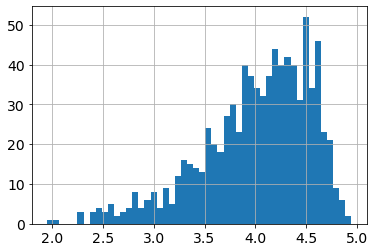

In [13]:
ratings_count['rating'].hist(bins=50)

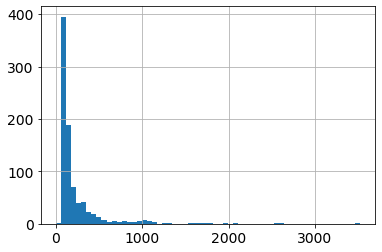

In [14]:
ratings_count['number_of_ratings'].hist(bins=60)

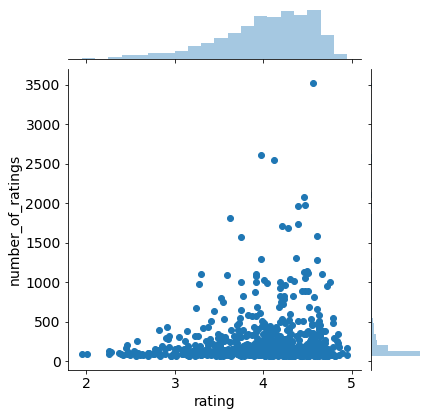

In [15]:
sns.jointplot(x='rating', y='number_of_ratings', data=ratings_count)

From the diagram we can see that their is a positive relationship between the average rating of a product and the number of ratings. The graph indicates that the more the ratings a product gets the higher the average rating it gets. This is important to note especially when choosing the threshold for the number of ratings per product.

In [16]:
sparsed_rating_df.groupby('productId')['rating'].mean().sort_values(ascending=False).head()  

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00006I53W    4.859551
B0000TU7I6    4.855263
Name: rating, dtype: float64

In [0]:
ratings_mean_count = pd.DataFrame(sparsed_rating_df.groupby('productId')['rating'].mean()) 

In [0]:
ratings_mean_count['rating_counts'] = pd.DataFrame(sparsed_rating_df.groupby('productId')['rating'].count())  

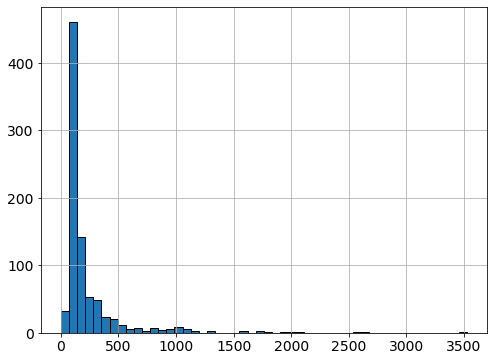

In [19]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

In [20]:
ratings_mean_count.head()  

,rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


Above shows the most popular products. We will explore item to item collaborative filtering to give a better recommendation. Popularity based recommendation will recommend the same set of products for every user. For example, it could recommend a hot selling product used by children for a user who has no use for it. To overcome this, we can go for item to item collaborative filtering. In this recommendation system, the products are recommended based on the items/products rated by the user.

In [21]:
sparsed_rating_df.head()

,userId,productId,rating,timestamp,count
0,A1BKC6B7YHYTVV,0972683275,4.0,1.405382e+09,1051
1,AWVFSIB42LHKJ,0972683275,4.0,1.405210e+09,1051
2,A36MQBNADRH8YY,0972683275,5.0,1.405642e+09,1051
3,A3SRXMPLAEZ6DP,0972683275,4.0,1.405987e+09,1051
4,A20XXTXWF2TCPY,0972683275,5.0,1.405123e+09,1051


In [22]:
sparsed_rating_df['rating'] = sparsed_rating_df['rating'].fillna(0).astype(int)
#sparsed_rating_df = sparsed_rating_df.fillna(0).astype({'rating': 'int32'}).dtypes
sparsed_rating_df['rating'] = sparsed_rating_df['rating'].astype('int32')
#sparsed_rating_df['rating'] = sparsed_rating_df['rating'].fillna(0)
#sparsed_rating_df.astype({'rating': 'int32'}).dtypes
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(sparsed_rating_df[['userId', 'productId', 'rating']], reader=reader)
trainset, testset = train_test_split(data, test_size=0.2)
sparsed_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195660 entries, 0 to 195659
Data columns (total 5 columns):
userId       195660 non-null object
productId    195660 non-null object
rating       195660 non-null int32
timestamp    195659 non-null float64
count        195660 non-null int64
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 8.2+ MB


In [23]:
results = cross_validate(SVD(), data, measures=['RMSE'], cv=3, verbose=True)
# Get results 
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(SVD).split(' ')[0].split('.')[-1]], index=['Algorithm']))
print ('test')
print(tmp)
  

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2516  1.2521  1.2551  1.2529  0.0015  
Fit time          8.90    8.98    8.98    8.95    0.03    
Test time         0.60    0.40    0.40    0.46    0.10    
test
test_rmse     1.25294
fit_time      8.95112
test_time    0.464635
Algorithm      <class
dtype: object


In [25]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)
test_pred = algo.test(testset)
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Item-based Model : Test Set
RMSE: 1.3249


1.3249351077363003

In [26]:
results = cross_validate(BaselineOnly(), data, measures=['RMSE'], cv=3, verbose=True)
# Get results 
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(SVD).split(' ')[0].split('.')[-1]], index=['Algorithm']))
print ('test')
print(tmp)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2496  1.2524  1.2496  1.2505  0.0013  
Fit time          0.88    0.95    0.99    0.94    0.05    
Test time         0.37    0.38    0.58    0.45    0.09    
test
test_rmse     1.25053
fit_time     0.942431
test_time    0.445196
Algorithm      <class
dtype: object


We can see that Baseline only algorithm gives us the best RSME value. BaselineOnly algorithm gave us the best rmse, therefore, we will train and predict with BaselineOnly and use Alternating Least Squares (ALS).

In [27]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.5156753063201904, 0.5462617874145508, 0.5426323413848877),
 'test_rmse': array([1.25016225, 1.24898806, 1.25086332]),
 'test_time': (0.404541015625, 0.5646774768829346, 0.3886544704437256)}

In [28]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.2452


1.2452478892480283

In [29]:
# run the trained model against the testset
test_pred = algo.test(testset)
test_pred

[Prediction(uid='A2R5MQ5T85FB78', iid='B00007EDZG', r_ui=5.0, est=4.390179091660837, details={'was_impossible': False}),
 Prediction(uid='A2W4GRVON8APBU', iid='B0000645RH', r_ui=4.0, est=3.2406490980384253, details={'was_impossible': False}),
 Prediction(uid='A3706BNPQXZZ36', iid='B00004VUGJ', r_ui=4.0, est=4.276881494851035, details={'was_impossible': False}),
 Prediction(uid='A39APYUHMVNYCF', iid='B0000DK5LW', r_ui=4.0, est=3.7584128497830522, details={'was_impossible': False}),
 Prediction(uid='ALEJDFCT3VCEA', iid='B00006RVPW', r_ui=5.0, est=4.470945573558729, details={'was_impossible': False}),
 Prediction(uid='A39NDW27G24P1L', iid='B00001OWYM', r_ui=1.0, est=3.168978330067828, details={'was_impossible': False}),
 Prediction(uid='A3HF257LGTGOTS', iid='0972683275', r_ui=5.0, est=4.472750777235683, details={'was_impossible': False}),
 Prediction(uid='A36DNPAH619EPW', iid='B00007IFED', r_ui=4.0, est=4.174131009942524, details={'was_impossible': False}),
 Prediction(uid='A3DELFJF2O2J4W

In [30]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.2452


1.2452478892480283

In [0]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [33]:
best_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
28277,A1MVSX9232K1XQ,B000053HC5,5.0,5.0,{'was_impossible': False},1,122,0.0
26517,A3GQKB1KF0CRPE,B00004Z5M1,5.0,5.0,{'was_impossible': False},10,616,0.0
34419,A3Q0KBS1XEF30I,B000053HC5,5.0,5.0,{'was_impossible': False},1,122,0.0
15087,A2W362SNNS6O6,B000053HC5,5.0,5.0,{'was_impossible': False},2,122,0.0
31035,A2JFOHC9W629IE,B00006I53X,5.0,5.0,{'was_impossible': False},5,188,0.0


The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 122 to 616, they are not really small, meaning that significant number of users have rated the product

In [34]:
worst_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
446,A1T8XII6RY0ZC7,B0000BZL1P,1.0,4.767396,{'was_impossible': False},0,736,3.767396
11499,A3GYXX7ZH7YAJ6,B0000BZL1P,1.0,4.767396,{'was_impossible': False},0,736,3.767396
16234,A1SV33K0SHQBSY,B0000BZL1P,1.0,4.767396,{'was_impossible': False},0,736,3.767396
15191,A2TZL219H1XLVH,B0000BZL1P,1.0,4.767396,{'was_impossible': False},0,736,3.767396
14396,A2J7LX31PMGQMV,B0000BZL1P,1.0,4.767396,{'was_impossible': False},0,736,3.767396


Above are the worst predictions as the actual rating is 1 but the estimated rating is near 5. 